# Table of Contents
- [Import Library](#import-library)
- [Read In CSV](#read-in-csv)
- [Functions](#functions)
- [Train RandomForest Model](#train-randomforest-model)
    - [Baseline Model](#baseline-model)
    - [GridSearched Model](#gridsearched-model)
- [Evaluate RandomForest Model](#evaluate-randomforest-model)

# Import Library

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

# Read in CSV

In [2]:
eth = pd.read_csv('./data/ohlcv_daily.csv')

# Functions

In [17]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name='predictions')
    combined = pd.concat([test['target'], preds], axis=1)
    
    plt.figure(figsize=(12,6))
    
    plt.plot(combined.index, combined['target'], label='Target')
    plt.plot(combined.index, combined['predictions'], label='Predictions')
    plt.legend()

    visualization_folder = 'visualizations'
    os.makedirs(visualization_folder, exist_ok=True)

    save_path = os.path.join(visualization_folder, f"visualization_{len(os.listdir(visualization_folder)) + 1}.png")
    plt.savefig(save_path)
    
    plt.show()
    
    return combined

In [5]:
# 3 years worth of historical data we want to use before we start making predictions and make predictions every 6 months
def backtest(data, model, predictors, start=1095, step=150): 
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

# Train RandomForest Model

## Model w/ No Feature Engineering

In [10]:
predictors = ['close', 'volume', 'open', 'high', 'low', 'edit_count', 'sentiment', 'negative_sentiment']

X = eth[predictors]
y = eth['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20, 50]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='precision', cv=3)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

final_rf_no_fe = RandomForestClassifier(random_state=42, **best_params)

final_rf_no_fe.fit(X_train, y_train)

preds = final_rf_no_fe.predict(X_test)

precision = precision_score(y_test, preds)
print("Precision:", precision)

Best Parameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
Precision: 0.5689655172413793


# Evaluate Model

## Backtest RandomForest Modem

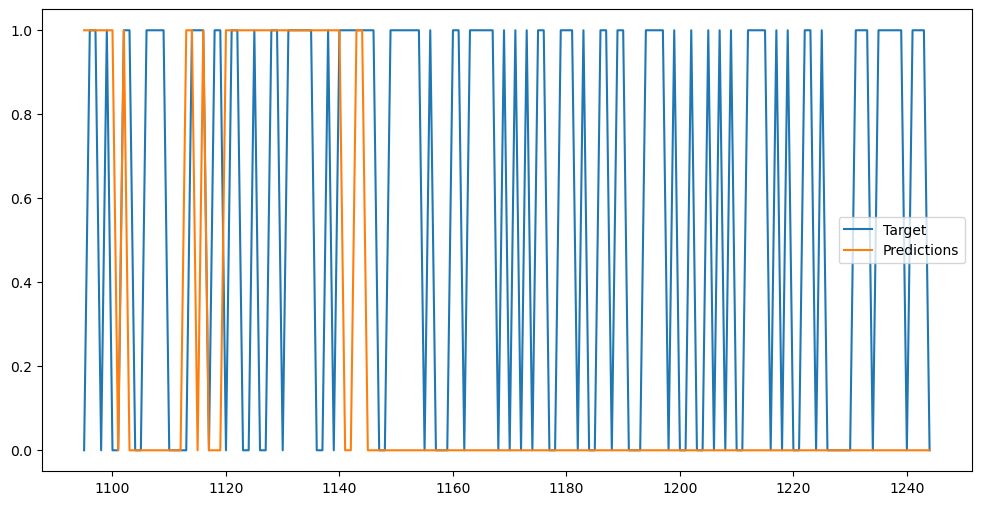

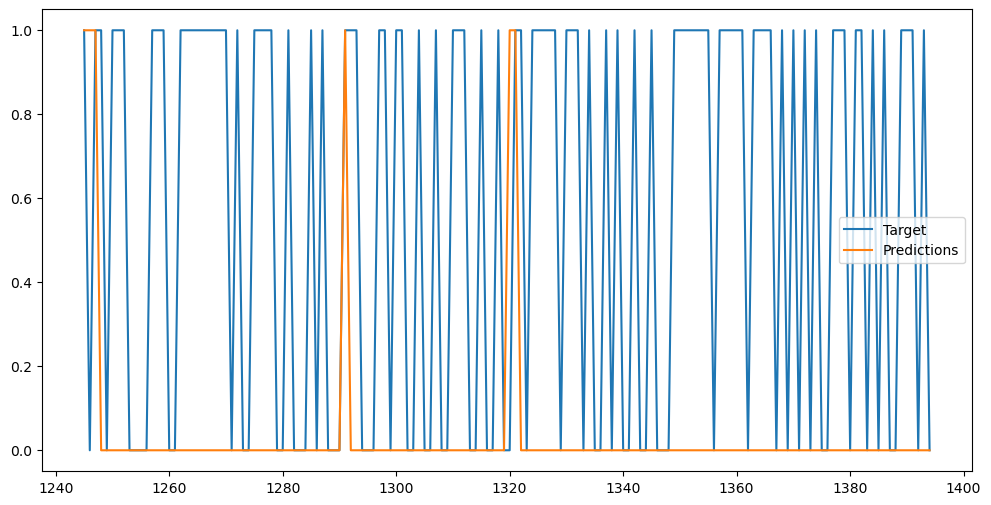

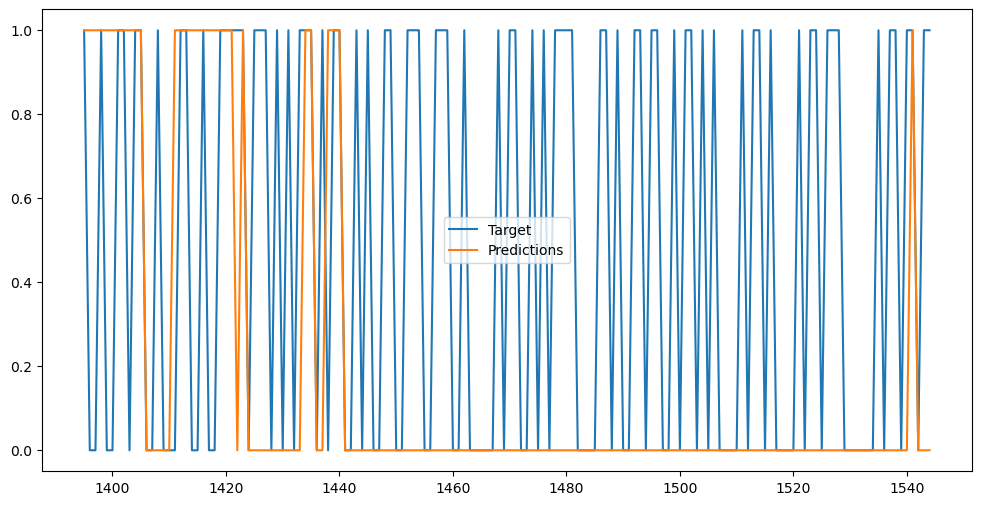

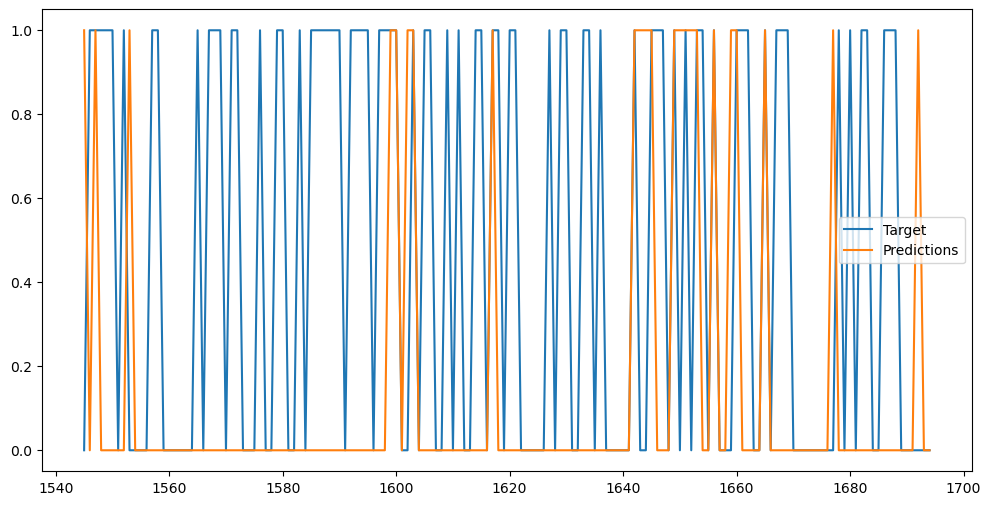

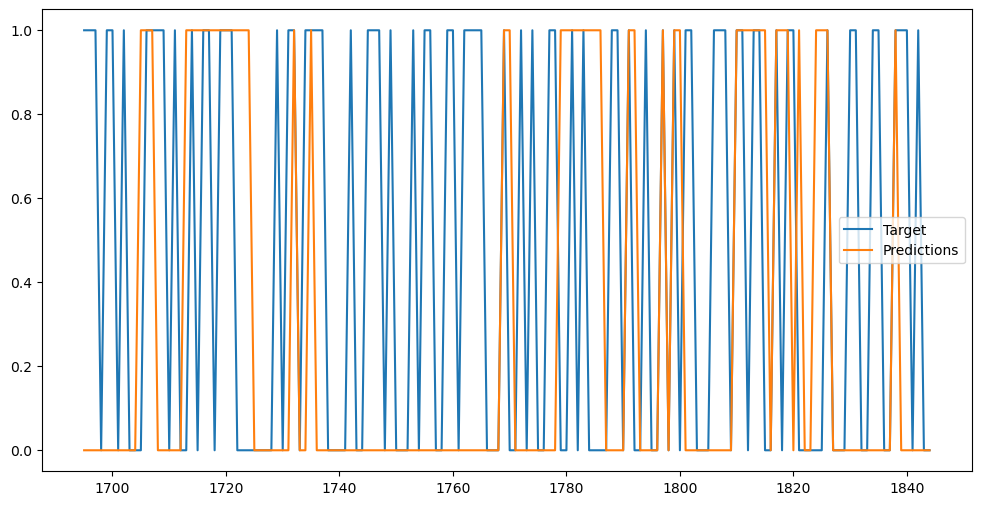

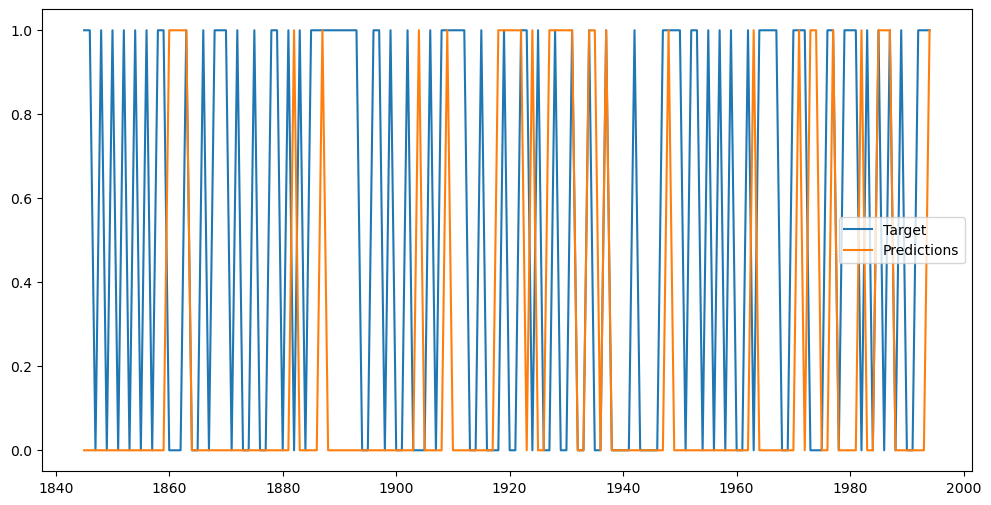

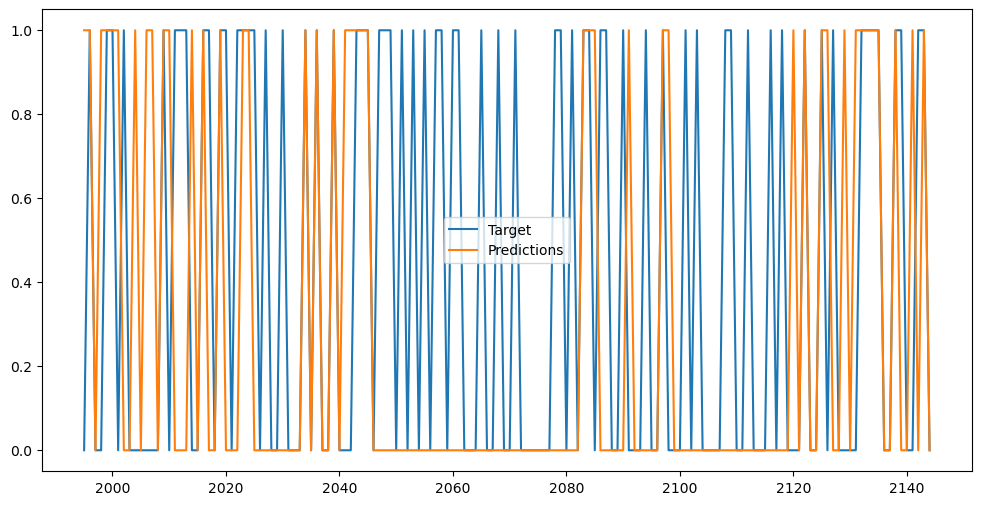

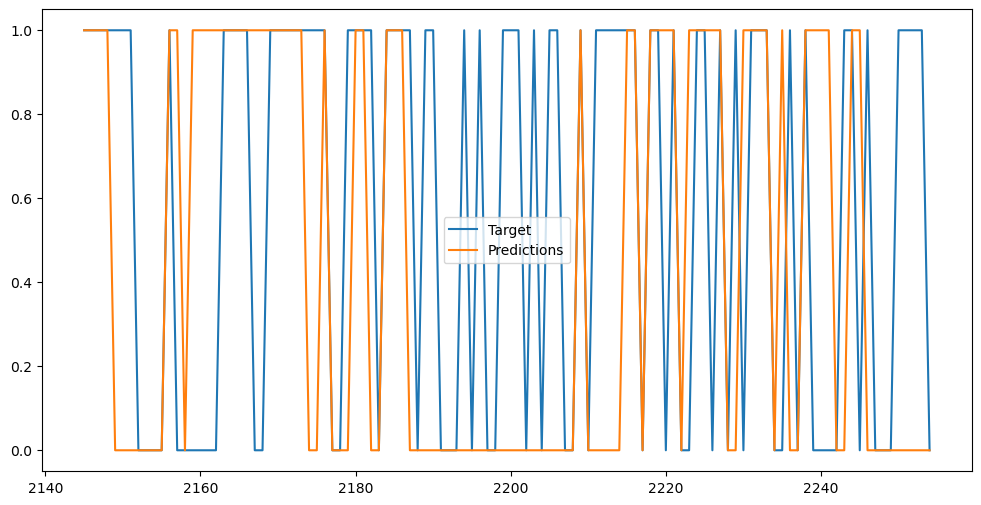

In [18]:
rf_no_fe_predictions = backtest(eth, final_rf_no_fe, predictors)

In [20]:
# Baseline
rf_no_fe_predictions['target'].value_counts() / rf_no_fe_predictions.shape[0]

1    0.517241
0    0.482759
Name: target, dtype: float64

In [21]:
rf_no_fe_predictions['predictions'].value_counts()

0    897
1    263
Name: predictions, dtype: int64

In [22]:
precision_score(rf_no_fe_predictions["target"], rf_no_fe_predictions["predictions"])

0.5817490494296578

Our baseline was 51% and after backtesting our RandomForest model we ended up with 58% accuracy